In [111]:
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
from scipy.stats import zscore

In [112]:
pd

<module 'pandas' from '/home/basti/.local/share/virtualenvs/teastore_experiments-gXtBjM1O/lib/python3.9/site-packages/pandas/__init__.py'>

In [113]:
DATA_DIR = "data"

In [114]:
experiment_dirs = sorted(glob("data/*"))
experiment_dirs

exp_dir = "data/2024-06-18_16-26-00" 

In [115]:
measurements = glob(exp_dir + "/*/*/*")
measurements

['data/2024-06-18_16-26-00/exp_scale/baseline_vanilla_cpu/0',
 'data/2024-06-18_16-26-00/exp_scale/jvm_jvm-impoove_cpu/0',
 'data/2024-06-18_16-26-00/exp_scale_rampup/baseline_vanilla_cpu/0']

In [116]:
def set_experiment_time(
    df, col="collection_time", target="experiment_time", where="run"
):
    missing_time = df[df[col] == "0"]
    print(f"{len(missing_time)} missing times")
    df.drop(missing_time.index, inplace=True)
    df[col] = pd.to_datetime(df[col])

    # the fancy way with different starting times:
    # df["run_starts"] = df.groupby(where)[col].transform("min")
    # df[target] = df[col] - df["run_starts"]

    # one experiment per df:
    df[target] = df[col] - df[col].min()


def drop_outliers(df, z_score_threshold=3):
    data_errors = 0

    common_keys = [
        "wattage_kepler",
        "wattage_scaph",
        # "wattage"
        "cpu_usage",
        "memory_usage",
        "network_usage",
    ]

    for key in common_keys:
        if key in df:
            df[f"{key}_zscore"] = zscore(df[key])

    for key in common_keys:
        outliers = df[df[f"{key}_zscore"].abs() > z_score_threshold].index
        data_errors += len(outliers)
        df = df.drop(outliers)

    print(f"dropped {data_errors} outliers")
    return data_errors


def measurement_file_to_df(file: str, prefix: str, treat=True):
    # no risk, no fun
    (_, pr_time, pr_scale, pr_branch, pr_run, pr_name) = file.split("/")
    pod_df = pd.read_csv(file)
    pod_df["exp_workload"] = pr_scale
    pod_df["exp_branch"] = pr_branch
    pod_df["exp_run_i"] = pr_run
    pod_df["exp_id"] = pr_name.replace(prefix, "").replace(".csv", "")

    pod_df["run"] = "_".join([pr_branch, pr_scale, pr_run])

    if treat:
        drop_outliers(pod_df)
        set_experiment_time(pod_df)

    return pod_df


def get_df_for_prefix(prefix, measurement_dirs, treat=True):
    pod_files = np.concatenate([glob(f"{d}/{prefix}*") for d in measurement_dirs])
    all_pods = pd.concat([measurement_file_to_df(pf, prefix, treat) for pf in pod_files])
    return all_pods

In [117]:
all_pods = get_df_for_prefix("measurements_pod_", measurements)
# set_experiment_time(all_pods)
# drop_outliers(all_pods)

all_nodes = get_df_for_prefix("measurements_node_", measurements)
# set_experiment_time(all_nodes)
# drop_outliers(all_nodes)

display(all_pods.describe())
display(all_nodes.describe())

all_nodes['experiment_time'].dtype

dropped 7 outliers
0 missing times
dropped 9 outliers
0 missing times
dropped 7 outliers
0 missing times
dropped 0 outliers
0 missing times
dropped 3 outliers
0 missing times
dropped 0 outliers
0 missing times


,collection_time,cpu_usage,memory_usage,network_usage,wattage_kepler,wattage_scaph,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
count,224,224.000000,224.000000,0.0,224.000000,224.000000,2.240000e+02,2.240000e+02,2.240000e+02,2.240000e+02,0.0,224
mean,2024-06-18 16:36:19.758928384,0.168941,325.873719,NaN,3.267649,0.075285,-3.965082e-17,3.172066e-17,-1.586033e-17,7.137148e-17,NaN,0 days 00:00:35.794642857
min,2024-06-18 16:30:25,0.000000,0.000000,NaN,0.000000,0.000000,-6.877125e-01,-4.548843e-01,-5.671718e-01,-9.560239e-01,NaN,0 days 00:00:00
25%,2024-06-18 16:31:26,0.000000,5.623808,NaN,0.000000,0.000000,-6.557412e-01,-4.425068e-01,-5.249508e-01,-7.228823e-01,NaN,0 days 00:00:20
50%,2024-06-18 16:36:31,0.000000,197.734400,NaN,0.000000,0.000000,-4.985948e-01,-3.922014e-01,-4.464272e-01,-3.581414e-01,NaN,0 days 00:00:40
75%,2024-06-18 16:40:54,0.132928,577.949696,NaN,7.696667,0.058946,8.280887e-01,-7.932078e-02,-7.554592e-02,5.897382e-01,NaN,0 days 00:01:00
max,2024-06-18 16:41:55,1.478194,1814.814720,NaN,23.158333,0.943184,3.864753e+00,4.191898e+00,3.750025e+00,3.106063e+00,NaN,0 days 00:01:11
std,NaN,0.344602,387.293845,NaN,5.342050,0.181993,1.002240e+00,1.002240e+00,1.002240e+00,1.002240e+00,NaN,0 days 00:00:23.275167541


,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,wattage_auxilary,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
count,144,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,144
mean,2024-06-18 16:36:18.624999936,0.659477,3763.737060,0.723776,17.111111,9.993056,0.011991,6.294645,0.051454,2.467162e-17,-2.081668e-17,-6.167906e-18,-6.630499e-17,-7.401487e-17,0 days 00:00:35.291666666
min,2024-06-18 16:30:25,0.034000,1532.837888,0.006307,0.000000,3.000000,0.000000,0.000000,0.000000,-8.208191e-01,-7.120401e-01,-7.110644e-01,-1.246958e+00,-8.152965e-01,0 days 00:00:00
25%,2024-06-18 16:31:23.500000,0.050667,1885.237248,0.049767,0.000000,5.000000,0.000000,0.000000,0.000000,-7.473754e-01,-6.971476e-01,-6.594241e-01,-9.495239e-01,-6.593042e-01,0 days 00:00:17.500000
50%,2024-06-18 16:36:36,0.234667,3536.738304,0.474832,0.000000,10.000000,0.000280,0.029972,0.000083,-7.096912e-01,-6.825176e-01,-4.643012e-01,-1.576923e-01,-2.573200e-01,0 days 00:00:35
75%,2024-06-18 16:40:56.500000,1.063750,5209.440256,0.749047,44.000000,14.000000,0.025685,15.221837,0.089915,9.419967e-01,1.031621e+00,3.139571e-01,7.565899e-01,4.057208e-02,0 days 00:00:53.250000
max,2024-06-18 16:41:55,3.369333,8762.257408,4.275078,85.000000,17.000000,0.061050,29.067256,0.358775,2.624540e+00,2.340414e+00,3.156492e+00,2.219370e+00,3.074556e+00,0 days 00:01:11
std,NaN,0.921776,1991.290211,0.994030,25.277788,4.656744,0.016042,9.077306,0.083452,1.003490e+00,1.003490e+00,1.003490e+00,1.003490e+00,1.003490e+00,0 days 00:00:23.278452775


dtype('<m8[ns]')

In [118]:
stats = get_df_for_prefix("teastore_stats.csv", measurements, treat=False)
stats

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,98%,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id,run
0,GET,/category,31,6,160.000000,1352.780465,13.965381,6769.538650,97932.354839,0.412257,...,6800,6800,6800,6800,6800,exp_scale,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_0
1,GET,/product,6,0,60.000000,430.299035,56.034443,2263.148542,123720.000000,0.079792,...,2300,2300,2300,2300,2300,exp_scale,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_0
2,NaN,Aggregated,37,6,150.000000,1203.188882,13.965381,6769.538650,102114.135135,0.492048,...,6800,6800,6800,6800,6800,exp_scale,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_0
0,POST,/cartAction | add to cart,1,0,4.086600,4.086600,4.086600,4.086600,0.000000,0.013297,...,4,4,4,4,4,exp_scale,jvm_jvm-impoove_cpu,0,,jvm_jvm-impoove_cpu_exp_scale_0
1,GET,/category,64,11,47.000000,273.610782,28.354213,6508.001231,57985.109375,0.850992,...,6500,6500,6500,6500,6500,exp_scale,jvm_jvm-impoove_cpu,0,,jvm_jvm-impoove_cpu_exp_scale_0
2,GET,/product,17,4,79.000000,449.419791,53.329609,1985.903212,48344.764706,0.226045,...,2000,2000,2000,2000,2000,exp_scale,jvm_jvm-impoove_cpu,0,,jvm_jvm-impoove_cpu_exp_scale_0
3,GET,/tools.descartes.teastore.webui/cart,1,0,1187.761168,1187.761168,1187.761168,1187.761168,9579.000000,0.013297,...,1200,1200,1200,1200,1200,exp_scale,jvm_jvm-impoove_cpu,0,,jvm_jvm-impoove_cpu_exp_scale_0
4,NaN,Aggregated,83,15,53.000000,317.386437,4.086600,6508.001231,54728.759036,1.103631,...,6500,6500,6500,6500,6500,exp_scale,jvm_jvm-impoove_cpu,0,,jvm_jvm-impoove_cpu_exp_scale_0
0,GET,/category,37,12,1000.000000,1938.186945,14.340585,6441.954481,60586.702703,0.473751,...,6400,6400,6400,6400,6400,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0
1,GET,/product,4,0,57.000000,66.472405,55.239207,91.234922,103198.250000,0.051216,...,91,91,91,91,91,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0


In [119]:
agg_stats = stats[stats['Name'] == "Aggregated"]
agg_stats

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,98%,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_run_i,exp_id,run
2,NaN,Aggregated,37,6,150.0,1203.188882,13.965381,6769.538650,102114.135135,0.492048,...,6800,6800,6800,6800,6800,exp_scale,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_0
4,NaN,Aggregated,83,15,53.0,317.386437,4.086600,6508.001231,54728.759036,1.103631,...,6500,6500,6500,6500,6500,exp_scale,jvm_jvm-impoove_cpu,0,,jvm_jvm-impoove_cpu_exp_scale_0
2,NaN,Aggregated,41,12,270.0,1755.580648,14.340585,6441.954481,64743.926829,0.524968,...,6400,6400,6400,6400,6400,exp_scale_rampup,baseline_vanilla_cpu,0,,baseline_vanilla_cpu_exp_scale_rampup_0


In [120]:
all_nodes

,instance,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,...,exp_branch,exp_run_i,exp_id,run,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
0,ise-knode6,2024-06-18 16:30:25,2024-06-18 16:30:25,0.266667,4568.248320,0.826326,44,17,0.037519,15.236004,...,baseline_vanilla_cpu,0,18_06_2024_16_30,baseline_vanilla_cpu_exp_scale_0,1.699736,1.034525,-0.464301,0.305272,0.028066,0 days 00:00:00
1,ise-knode3,2024-06-18 16:30:25,2024-06-18 16:30:25,0.049333,1532.874752,0.063350,0,5,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_30,baseline_vanilla_cpu_exp_scale_0,-0.820819,-0.712040,-0.668743,-1.080037,-0.625462,0 days 00:00:00
2,ise-knode2,2024-06-18 16:30:25,2024-06-18 16:30:25,0.082667,1885.237248,0.009347,0,4,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_30,baseline_vanilla_cpu_exp_scale_0,-0.820819,-0.712040,-0.637387,-0.919223,-0.671718,0 days 00:00:00
3,ise-kmaster,2024-06-18 16:30:25,2024-06-18 16:30:25,0.287667,2532.298752,0.687063,0,10,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_30,baseline_vanilla_cpu_exp_scale_0,-0.820819,-0.712040,-0.444547,-0.623912,-0.091220,0 days 00:00:00
4,ise-knode1,2024-06-18 16:30:25,2024-06-18 16:30:25,0.194667,4755.492864,0.633939,0,14,0.000657,0.061549,...,baseline_vanilla_cpu,0,18_06_2024_16_30,baseline_vanilla_cpu_exp_scale_0,-0.776667,-0.704985,-0.532030,0.390729,-0.136723,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,ise-knode3,2024-06-18 16:41:55,2024-06-18 16:41:55,0.037667,1533.784064,0.019312,0,5,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_40,baseline_vanilla_cpu_exp_scale_rampup_0,-0.709691,-0.682518,-0.709960,-1.113810,-0.799431,0 days 00:01:11
44,ise-knode2,2024-06-18 16:41:55,2024-06-18 16:41:55,0.046667,1887.764480,0.205561,0,4,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_40,baseline_vanilla_cpu_exp_scale_rampup_0,-0.709691,-0.682518,-0.700020,-0.944294,-0.572210,0 days 00:01:11
45,ise-kmaster,2024-06-18 16:41:55,2024-06-18 16:41:55,0.234682,2537.644032,0.426062,0,10,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_40,baseline_vanilla_cpu_exp_scale_rampup_0,-0.709691,-0.682518,-0.492364,-0.633076,-0.303203,0 days 00:01:11
46,ise-knode1,2024-06-18 16:41:55,2024-06-18 16:41:55,2.295000,8120.721408,0.780387,0,14,0.009166,0.584547,...,baseline_vanilla_cpu,0,18_06_2024_16_40,baseline_vanilla_cpu_exp_scale_rampup_0,-0.209117,-0.621726,1.783175,2.040583,0.129067,0 days 00:01:11


In [121]:
all_pods.groupby(all_pods['name'])[['cpu_usage', 'memory_usage', 'wattage_kepler', 'wattage_scaph']].describe(percentiles=[])

cpu_usage                                               \
                           count      mean       std  min       50%       max   
name                                                                            
loadgenerator               23.0  0.007023  0.009462  0.0  0.000000  0.024530   
teastore-auth-0             23.0  0.183022  0.254718  0.0  0.070719  0.665518   
teastore-auth-1              4.0  0.000000  0.000000  0.0  0.000000  0.000000   
teastore-db-0               24.0  0.050787  0.052869  0.0  0.039297  0.124127   
teastore-image-0            23.0  0.401481  0.560621  0.0  0.096329  1.478194   
teastore-image-1             5.0  0.000000  0.000000  0.0  0.000000  0.000000   
teastore-persistence-0      23.0  0.202645  0.247917  0.0  0.069626  0.659537   
teastore-recommender-0      24.0  0.151487  0.193852  0.0  0.044029  0.516891   
teastore-registry-0         24.0  0.088654  0.082597  0.0  0.045402  0.239333   
teastore-webui-0            23.0  0.547588  0.638597  0.0  0.238000  1.464610   
teastore-webui-1             4.0  0.000000  0.000000  0.0  0.000000  0.000000   
teastore-webui-2            24.0  0.000000  0.000000  0.0  0.000000  0.000000   

                       memory_usage                                        \
                              count         mean         std          min   
name                                                                        
loadgenerator                  23.0    39.309846   21.788556     3.325952   
teastore-auth-0                23.0   403.658663  279.788670     3.547136   
teastore-auth-1                 4.0   482.082816    0.000000   482.082816   
teastore-db-0                  24.0   123.177643   52.209550     0.000000   
teastore-image-0               23.0   410.380021  490.816083     4.091904   
teastore-image-1                5.0   490.106880  447.404323     0.000000   
teastore-persistence-0         23.0   548.302670  291.819024     3.178496   
teastore-recommender-0         24.0   680.842581  419.328633     5.623808   
teastore-registry-0            24.0   296.313856  125.177778     3.534848   
teastore-webui-0               23.0   255.609990  567.120213     3.190784   
teastore-webui-1                4.0  1022.955520    0.000000  1022.955520   
teastore-webui-2               24.0     0.000000    0.000000     0.000000   

                        ... wattage_kepler                            \
                        ...            std  min       50%        max   
name                    ...                                            
loadgenerator           ...       0.000000  0.0  0.000000   0.000000   
teastore-auth-0         ...       3.898033  0.0  0.216667  10.370000   
teastore-auth-1         ...       0.000000  0.0  0.000000   0.000000   
teastore-db-0           ...       9.499613  0.0  4.468333  23.158333   
teastore-image-0        ...       3.608153  0.0  0.000000   9.896667   
teastore-image-1        ...       0.000000  0.0  0.000000   0.000000   
teastore-persistence-0  ...       4.434312  0.0  7.970000  10.370000   
teastore-recommender-0  ...       4.673653  0.0  3.848333  10.370000   
teastore-registry-0     ...       4.077542  0.0  8.315000  10.370000   
teastore-webui-0        ...       0.344325  0.0  0.216667   0.816667   
teastore-webui-1        ...       0.000000  0.0  0.000000   0.000000   
teastore-webui-2        ...       0.000000  0.0  0.000000   0.000000   

                       wattage_scaph                                     \
                               count      mean       std  min       50%   
name                                                                      
loadgenerator                   23.0  0.000000  0.000000  0.0  0.000000   
teastore-auth-0                 23.0  0.101054  0.238346  0.0  0.000000   
teastore-auth-1                  4.0  0.000000  0.000000  0.0  0.000000   
teastore-db-0                   24.0  0.028319  0.027210  0.0  0.024594   
teastore-image-0                23.0  0.06708

<Axes: xlabel='experiment_time', ylabel='wattage_scaph'>

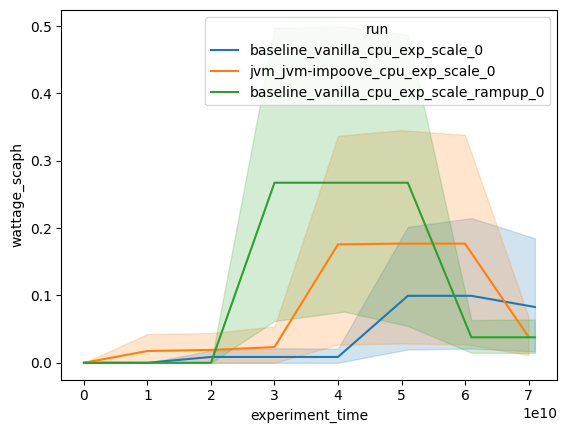

In [122]:
sns.lineplot(data=all_pods, x="experiment_time", y="wattage_scaph", hue="run")

In [123]:
all_nodes

,instance,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,...,exp_branch,exp_run_i,exp_id,run,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,experiment_time
0,ise-knode6,2024-06-18 16:30:25,2024-06-18 16:30:25,0.266667,4568.248320,0.826326,44,17,0.037519,15.236004,...,baseline_vanilla_cpu,0,18_06_2024_16_30,baseline_vanilla_cpu_exp_scale_0,1.699736,1.034525,-0.464301,0.305272,0.028066,0 days 00:00:00
1,ise-knode3,2024-06-18 16:30:25,2024-06-18 16:30:25,0.049333,1532.874752,0.063350,0,5,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_30,baseline_vanilla_cpu_exp_scale_0,-0.820819,-0.712040,-0.668743,-1.080037,-0.625462,0 days 00:00:00
2,ise-knode2,2024-06-18 16:30:25,2024-06-18 16:30:25,0.082667,1885.237248,0.009347,0,4,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_30,baseline_vanilla_cpu_exp_scale_0,-0.820819,-0.712040,-0.637387,-0.919223,-0.671718,0 days 00:00:00
3,ise-kmaster,2024-06-18 16:30:25,2024-06-18 16:30:25,0.287667,2532.298752,0.687063,0,10,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_30,baseline_vanilla_cpu_exp_scale_0,-0.820819,-0.712040,-0.444547,-0.623912,-0.091220,0 days 00:00:00
4,ise-knode1,2024-06-18 16:30:25,2024-06-18 16:30:25,0.194667,4755.492864,0.633939,0,14,0.000657,0.061549,...,baseline_vanilla_cpu,0,18_06_2024_16_30,baseline_vanilla_cpu_exp_scale_0,-0.776667,-0.704985,-0.532030,0.390729,-0.136723,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,ise-knode3,2024-06-18 16:41:55,2024-06-18 16:41:55,0.037667,1533.784064,0.019312,0,5,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_40,baseline_vanilla_cpu_exp_scale_rampup_0,-0.709691,-0.682518,-0.709960,-1.113810,-0.799431,0 days 00:01:11
44,ise-knode2,2024-06-18 16:41:55,2024-06-18 16:41:55,0.046667,1887.764480,0.205561,0,4,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_40,baseline_vanilla_cpu_exp_scale_rampup_0,-0.709691,-0.682518,-0.700020,-0.944294,-0.572210,0 days 00:01:11
45,ise-kmaster,2024-06-18 16:41:55,2024-06-18 16:41:55,0.234682,2537.644032,0.426062,0,10,0.000000,0.000000,...,baseline_vanilla_cpu,0,18_06_2024_16_40,baseline_vanilla_cpu_exp_scale_rampup_0,-0.709691,-0.682518,-0.492364,-0.633076,-0.303203,0 days 00:01:11
46,ise-knode1,2024-06-18 16:41:55,2024-06-18 16:41:55,2.295000,8120.721408,0.780387,0,14,0.009166,0.584547,...,baseline_vanilla_cpu,0,18_06_2024_16_40,baseline_vanilla_cpu_exp_scale_rampup_0,-0.209117,-0.621726,1.783175,2.040583,0.129067,0 days 00:01:11


In [124]:
all_nodes.groupby(['exp_workload', 'exp_branch', 'run']).describe()

collection_time  \
                                                                                        count   
exp_workload     exp_branch           run                                                       
exp_scale        baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_0                     48   
                 jvm_jvm-impoove_cpu  jvm_jvm-impoove_cpu_exp_scale_0                      48   
exp_scale_rampup baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_rampup_0              48   

                                                                                                              \
                                                                                                        mean   
exp_workload     exp_branch           run                                                                      
exp_scale        baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_0         2024-06-18 16:31:00.374999808   
                 jvm_jvm-impoove_cpu  jvm_jvm-impoove_cpu_exp_scale_0                    2024-06-18 16:36:36   
exp_scale_rampup baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_rampup_0  2024-06-18 16:41:19.500000256   

                                                                                                    \
                                                                                               min   
exp_workload     exp_branch           run                                                            
exp_scale        baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_0         2024-06-18 16:30:25   
                 jvm_jvm-impoove_cpu  jvm_jvm-impoove_cpu_exp_scale_0          2024-06-18 16:36:01   
exp_scale_rampup baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_rampup_0  2024-06-18 16:40:44   

                                                                                                           \
                                                                                                      25%   
exp_workload     exp_branch           run                                                                   
exp_scale        baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_0         2024-06-18 16:30:42.500000   
                 jvm_jvm-impoove_cpu  jvm_jvm-impoove_cpu_exp_scale_0          2024-06-18 16:36:18.500000   
exp_scale_rampup baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_rampup_0  2024-06-18 16:41:01.500000   

                                                                                                           \
                                                                                                      50%   
exp_workload     exp_branch           run                                                                   
exp_scale        baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_0                2024-06-18 16:31:00   
                 jvm_jvm-impoove_cpu  jvm_jvm-impoove_cpu_exp_scale_0                 2024-06-18 16:36:36   
exp_scale_rampup baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_rampup_0  2024-06-18 16:41:19.500000   

                                                                                                           \
                                                                                                      75%   
exp_workload     exp_branch           run                                                                   
exp_scale        baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_0         2024-06-18 16:31:18.500000   
                 jvm_jvm-impoove_cpu  jvm_jvm-impoove_cpu_exp_scale_0          2024-06-18 16:36:53.500000   
exp_scale_rampup baseline_vanilla_cpu baseline_vanilla_cpu_exp_scale_rampup_0  2024-06-18 16:41:37.500000   

                                                                                                    \
                                                                                               max   
exp_workload     exp_branch           ru

<Axes: xlabel='experiment_time', ylabel='cpu_usage'>

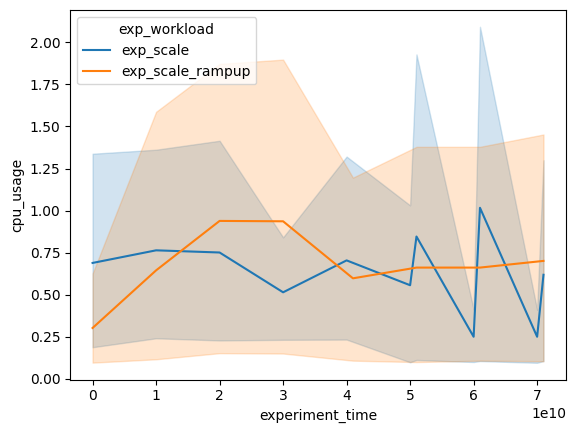

In [125]:
sns.lineplot(data=all_nodes, x="experiment_time", y="cpu_usage", hue="exp_workload")

<Axes: xlabel='experiment_time', ylabel='memory_usage'>

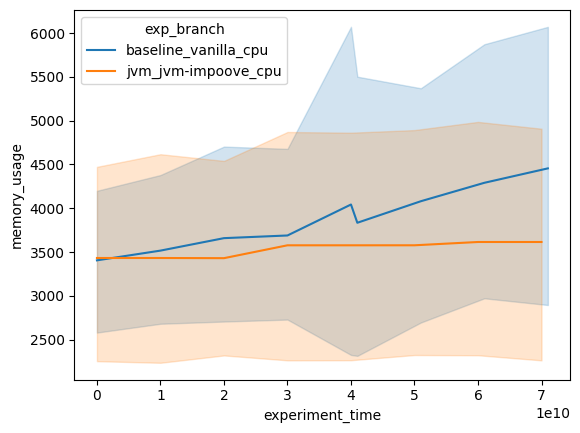

In [126]:
sns.lineplot(data=all_nodes, x="experiment_time", y="memory_usage", hue="exp_branch")

<Axes: xlabel='experiment_time', ylabel='memory_usage'>

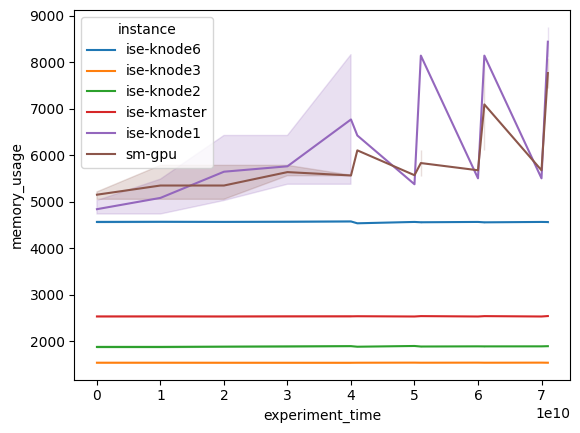

In [127]:
sns.lineplot(data=all_nodes, x="experiment_time", y="memory_usage", hue="instance")

In [128]:
wattage_fields = ["wattage", "wattage_kepler", "wattage_scaph", "wattage_auxilary"]
wattage_df = pd.melt(frame=all_nodes, id_vars=("exp_workload", "exp_branch", "experiment_time"), value_vars=wattage_fields)

display(wattage_df)
# sns.pairplot(data=wattage_df, x="experiment_time", y="value", hue="variable")


,exp_workload,exp_branch,experiment_time,variable,value
0,exp_scale,baseline_vanilla_cpu,0 days 00:00:00,wattage,44.000000
1,exp_scale,baseline_vanilla_cpu,0 days 00:00:00,wattage,0.000000
2,exp_scale,baseline_vanilla_cpu,0 days 00:00:00,wattage,0.000000
3,exp_scale,baseline_vanilla_cpu,0 days 00:00:00,wattage,0.000000
4,exp_scale,baseline_vanilla_cpu,0 days 00:00:00,wattage,0.000000
...,...,...,...,...,...
571,exp_scale_rampup,baseline_vanilla_cpu,0 days 00:01:11,wattage_auxilary,0.000000
572,exp_scale_rampup,baseline_vanilla_cpu,0 days 00:01:11,wattage_auxilary,0.000000
573,exp_scale_rampup,baseline_vanilla_cpu,0 days 00:01:11,wattage_auxilary,0.000000
574,exp_scale_rampup,baseline_vanilla_cpu,0 days 00:01:11,wattage_auxilary,0.001820


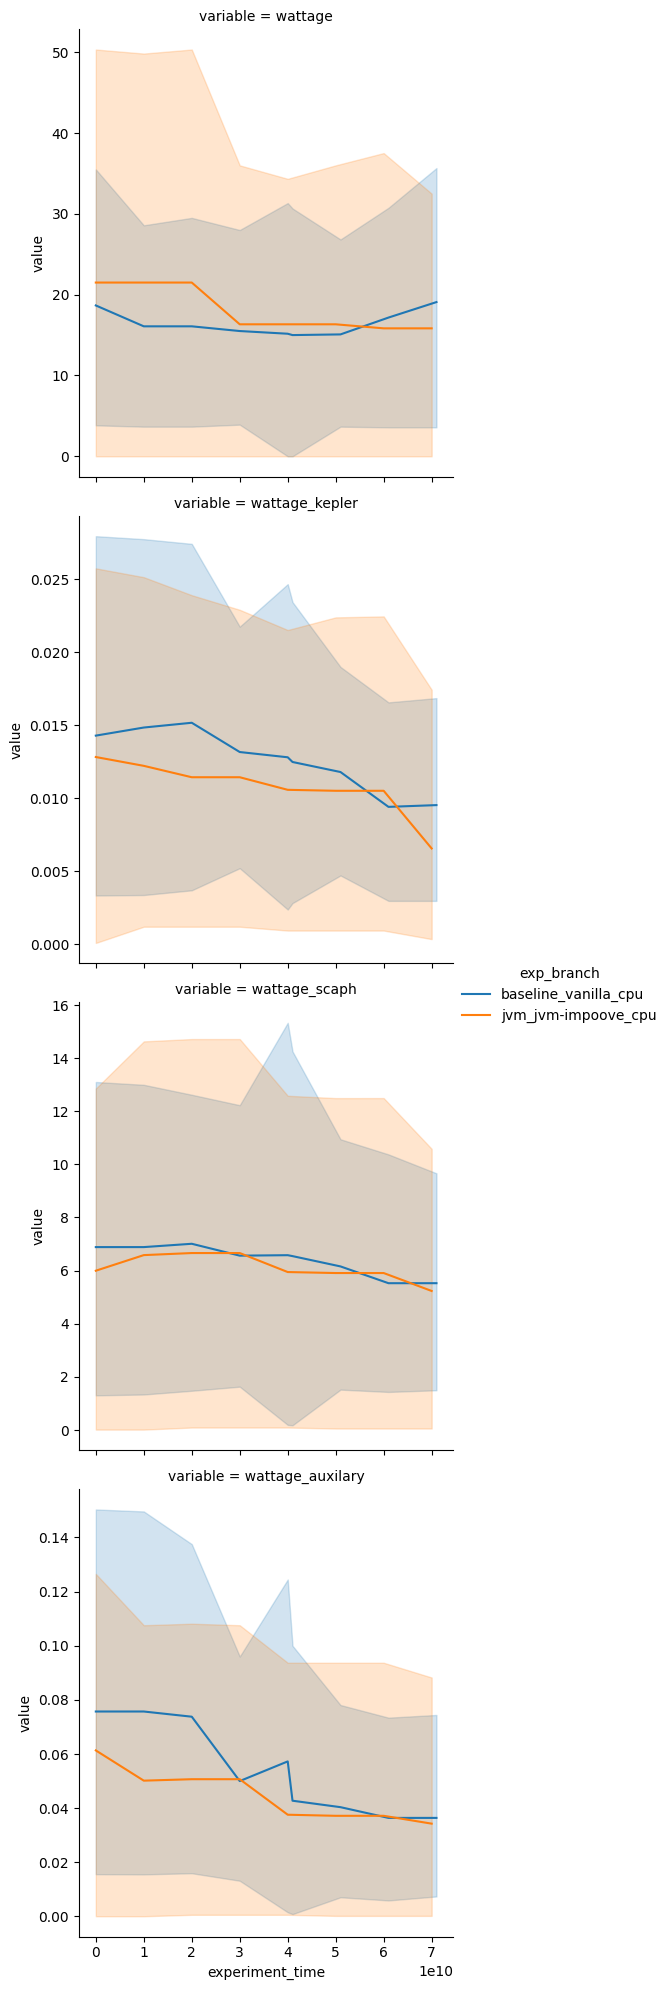

In [129]:
sns.relplot(
    data=wattage_df,
    kind="line",
    x="experiment_time",
    y="value",
    row="variable",
    # row="exp_workload",
    hue="exp_branch",
    facet_kws=dict(sharey=False),
)

In [130]:
all_nodes.dtypes

instance                          object
observation_time                  object
collection_time           datetime64[ns]
cpu_usage                        float64
memory_usage                     float64
network_usage                    float64
wattage                            int64
num_processes                      int64
wattage_kepler                   float64
wattage_scaph                    float64
wattage_auxilary                 float64
exp_workload                      object
exp_branch                        object
exp_run_i                         object
exp_id                            object
run                               object
wattage_kepler_zscore            float64
wattage_scaph_zscore             float64
cpu_usage_zscore                 float64
memory_usage_zscore              float64
network_usage_zscore             float64
experiment_time          timedelta64[ns]
dtype: object